In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cd '/content/drive/My Drive/course-v4' && git pull
!cd '/content/drive/My Drive/fastbook' && git pull

Already up to date.


In [0]:
%cd '/content/drive/My Drive/fastbook'
!pip install -r requirements.txt

In [123]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

---

# Data Augmentation Techniques to improve model

---

In [107]:
colab_models = '/content/drive/My Drive/models/'
gcp_models = '/home/jupyter/models/'

## Progressive Resizing

In [0]:
!nvidia-smi

In [108]:
from fastai2.vision.all import *

In [4]:
pwd

'/home/jupyter/my_fastai_notebooks/Vision'

In [22]:
path = untar_data(URLs.FLOWERS)
df = pd.read_csv('data/df.csv', index_col=0)

In [23]:
df.head()

,name,label,class
0,jpg/image_03860.jpg,16,purple coneflower
1,jpg/image_06092.jpg,13,spear thistle
2,jpg/image_02400.jpg,42,sword lily
3,jpg/image_02852.jpg,55,bishop of llandaff
4,jpg/image_07710.jpg,96,mallow


In [40]:
# The `get_dls` function for PR

def get_x(r): return path/r['name']
def get_y(r): return r['class']

def get_dls(bs, size):
  item_tfms=Resize(460),
  batch_tfms=aug_transforms(size=size, min_scale=0.75)
  dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=RandomSplitter(seed=42),
                    get_x= get_x,
                    get_y= get_y, 
                    item_tfms = item_tfms,
                    batch_tfms = batch_tfms)
  return dblock.dataloaders(df, bs=bs)

In [47]:
# getting a dataloader of bs=64 and size=
dls = get_dls(64, 128)
# dls.show_batch(max_n=3)

In [48]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

In [49]:
learn.fine_tune(5, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,5.009634,2.717970,0.387294,00:24
1,2.440333,0.974030,0.755651,00:25
2,1.319628,0.663012,0.819181,00:24


epoch,train_loss,valid_loss,accuracy,time
0,0.702690,0.431861,0.885156,00:25
1,0.514514,0.332444,0.907147,00:25
2,0.288868,0.268254,0.923641,00:25
3,0.163182,0.219667,0.935858,00:25
4,0.114966,0.215249,0.939524,00:24


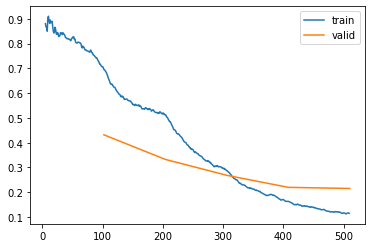

In [50]:
learn.recorder.plot_loss()

We can see that the validation loss is slowly about to spike which indicates a bit of overfitting which we saw in the previous post it's okay to happen! The most import important vlaue we care about is the accuracy i.e. the metric!

In [51]:
# Using tta on resnet34 arch of images model
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9480757713317871

In [52]:
learn.save(f'{gcp_models}flowers-resnet34-pr-128')

Again a little overfitting is not bad if your metric is actually improving!

In [38]:
learn.load(f'{gcp_models}flowers-resnet34-pr-128')

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=1.0964781722577754e-06)

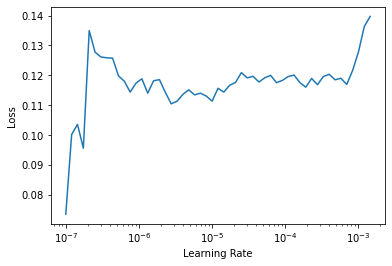

In [53]:
learn.lr_find()

In [54]:
# Changing the models dataloader to one of bs=64 and size=12
learn.dls = get_dls(64, 256)

In [55]:
learn.fine_tune(5, freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,time
0,0.307788,0.149626,0.955406,00:27


epoch,train_loss,valid_loss,accuracy,time
0,0.155823,0.110443,0.966402,00:31
1,0.137526,0.125121,0.962126,00:31
2,0.092230,0.070768,0.978009,00:31
3,0.050006,0.057295,0.982896,00:31
4,0.030974,0.053728,0.982285,00:31


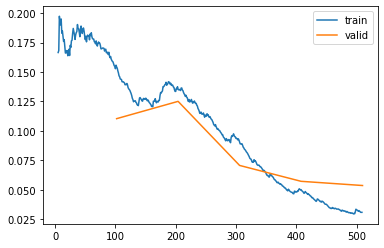

In [56]:
learn.recorder.plot_loss()

In [57]:
# Using tta on resnet34 arch of images model
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9883934259414673

In [58]:
learn.save(f'{gcp_models}flowers-resnet34-pr-256')

In [62]:
learn.load(f'{gcp_models}flowers-resnet34-pr-256')
# learn.validate()

SuggestedLRs(lr_min=5.754399353463669e-07, lr_steep=1.9054607491852948e-06)

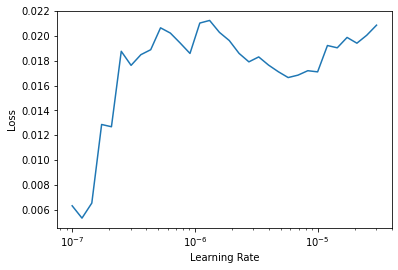

In [60]:
learn.lr_find()

In [63]:
learn.fit_one_cycle(5, lr_max=7e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.021434,0.056014,0.983506,00:31
1,0.018851,0.051082,0.982285,00:31
2,0.017763,0.047349,0.984728,00:31
3,0.019473,0.047070,0.985950,00:31
4,0.017664,0.048271,0.986561,00:31


In [64]:
# Using tta on resnet34 arch of images model
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9871716499328613

In [76]:
learn.load(f'{gcp_models}flowers-resnet50-pr-256')

In [77]:
# Changing the models dataloader to one of bs=64 and size=500*500
learn.dls = get_dls(64, 500)

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=6.309573450380412e-07)

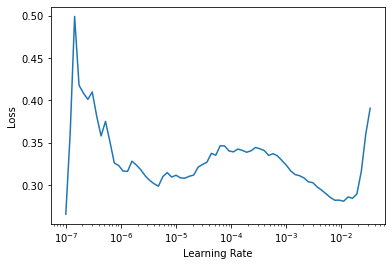

In [72]:
learn.lr_find()

In [78]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.222066,0.122021,0.967013,01:06


epoch,train_loss,valid_loss,accuracy,time
0,0.095071,0.083590,0.973732,01:28
1,0.118162,0.156416,0.951741,01:27
2,0.086160,0.072166,0.981063,01:27
3,0.036099,0.052197,0.984117,01:27
4,0.025953,0.045577,0.987783,01:27


In [79]:
# tta
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9890042543411255

In [80]:
learn.save(f'{gcp_models}flowers-resnet34-pr-500')

In [90]:
learn.load(f'{gcp_models}flowers-resnet34-pr-500')

---
## Mixup

In [126]:
item_tfms=Resize(460),
batch_tfms=aug_transforms(size=224, min_scale=0.75)

def get_x(r): return path/r['name']
def get_y(r): return r['class']

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x= get_x,
                   get_y= get_y, 
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)
dls = dblock.dataloaders(df) 

In [133]:
from fastai2.vision.core import *
from fastai2.callback.fp16 import *
mixup = MixUp(0.5)
learn = cnn_learner(dls, resnet50, metrics=accuracy, cbs=mixup, loss_func=LabelSmoothingCrossEntropy()).to_fp16()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.00363078061491251)

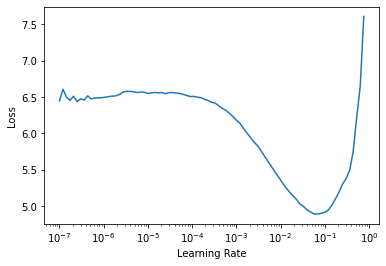

In [114]:
learn.lr_find()

In [134]:
learn.fit_one_cycle(30, lr_max=slice(3e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.584875,1.459459,0.843005,00:36
1,2.789904,1.300712,0.887599,00:36
2,2.528220,1.244440,0.915089,00:36
3,2.405344,1.201225,0.927306,00:36
4,2.337375,1.220200,0.906536,00:36
5,2.234967,1.179823,0.937080,00:36
6,2.172456,1.177402,0.931582,00:36
7,2.096805,1.192331,0.915699,00:36
8,2.069195,1.140021,0.940134,00:36
9,2.041453,1.160288,0.927306,00:36


In [124]:
learn.validate()

(#2) [0.14194084703922272,0.9810629487037659]

---